In [7]:
%%html
<style>
#notebook-container {
    width: 90%;
    background-color: #EEE
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .output_wrapper {
    width: 50%;
    background-color: #FFF
}

.code_cell .input {
    width: 50%;
    background-color: #FFF
}
</style>

In [5]:
import mne_bids
from pathlib import Path
import pandas as pd
import mne
from utils import match_list
from dataset import mne_events
from utils import add_syntax
from utils import match_list

from plot import plot_subject

from dataset import get_path, get_subjects, get_code_path
import numpy as np
import matplotlib.pyplot as plt

mne.set_log_level(False)

CHAPTERS = {
    1: "1-3",
    2: "4-6",
    3: "7-9",
    4: "10-12",
    5: "13-14",
    6: "15-19",
    7: "20-22",
    8: "23-25",
    9: "26-27",
}

# read one subject

In [124]:
def read_raw(subject, run_id):
    path = get_path("LPP_read")
    subjects = get_subjects(path)
    task = "read"
    baseline_min = -2.0
    baseline_max = 0.5
    epoch_on = 'sentence'
    reference = "end"
    print(f"\n Epoching for run {run_id}, subject: {subject}\n")
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )

    raw = mne_bids.read_raw_bids(bids_path)
    raw.del_proj()  # To fix proj issues
    raw.pick_types(meg=True, stim=True)
    
    # Generate event_file path
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()

    # read events
    meta = pd.read_csv(event_file, sep="\t")
    events = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    
    # Enriching the metadata with outside files:
    path_syntax = get_code_path() / "data/syntax"
    meta, syn = add_syntax(meta, path_syntax, int(run_id))
    
    # add sentence and word positions
    meta['sequence_id'] = np.cumsum(meta.is_last_word.shift(1, fill_value=False))
    for s, d in meta.groupby('sequence_id'):
        meta.loc[d.index, 'word_id'] = range(len(d))
        
    # XXX FIXME
    i, j = match_list(events[:, 2], meta.word.apply(len))
    assert len(i) > (.9 * len(events))
    meta['has_trigger'] = False
    meta.loc[j, 'has_trigger'] = True
    assert (events[i, 2] == meta.loc[j].word.apply(len)).mean() > .95
    
    # integrate events to meta for simplicity
    meta.loc[j, 'start'] = events[i, 0] / raw.info['sfreq']
        
    # preproc raw
    raw.load_data()
    raw = raw.filter(0.5, 20)
    
    return raw, meta

raw, meta = read_raw(subject='3', run_id=1)


 Epoching for run 1, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


# preproc raw

In [125]:
all_epochs = []
for run_id in range(1, 10):
    print('.', end='')
    raw, meta = read_raw(subject='3', run_id=run_id)
    
    # FIXME
    meta = meta.query('has_trigger').reset_index(drop=True)
    mne_events = np.ones((len(meta), 3), dtype=int)
    mne_events[:, 0] = meta.start * raw.info['sfreq']
    sent_events = meta.query('word_id==0')
    assert len(sent_events)
    
    epochs = mne.Epochs(
        raw, 
        mne_events[sent_events.index], 
        metadata=sent_events, 
        tmin=-.500, 
        tmax=2., 
        decim=10,
        preload=True,
        #event_repeated='drop'  # WHY DOES THIS OCCUR
    )
    all_epochs.append(epochs)

.
 Epoching for run 1, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.
 Epoching for run 2, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 99 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.
 Epoching for run 3, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 146 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.
 Epoching for run 4, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 134 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.
 Epoching for run 5, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 121 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.
 Epoching for run 6, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 139 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.
 Epoching for run 7, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 140 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.
 Epoching for run 8, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 116 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.
 Epoching for run 9, subject: 3



/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Omitted 148 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_81331/2822309783.py:19: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


In [129]:
for epo in all_epochs:
    epo.info['dev_head_t'] = all_epochs[1].info['dev_head_t']

In [130]:
epochs = mne.concatenate_epochs(all_epochs)

/tmp/ipykernel_81331/3234039719.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


In [132]:
evo = epochs.average(method='median')

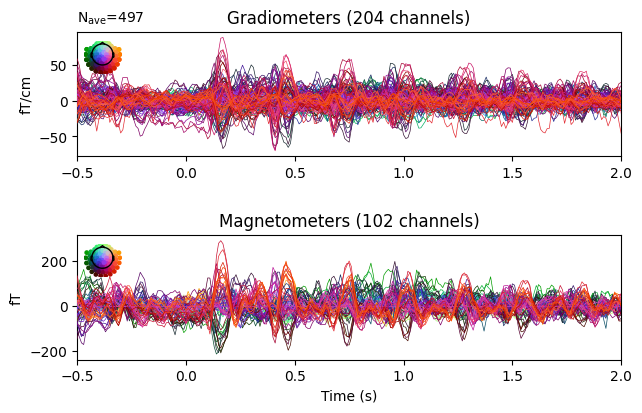

In [134]:
evo.plot();

# TODO
- FIX syntax parser: some sentences are merged
- understand why the number of triggers is different from the metadata -> currently using match_list as a proxy
- same analysis, using last word: attention, the trick is to get the bqseline from the preceding first word!
- same analysis in time frequency